# 1. Configuration and Data Generation

This cell handles the necessary imports, defines the experiment configuration (dimensions, vector count), and generates the normalized dummy data for Cosine distance comparison.

In [1]:
import numpy as np
import hnswlib
import time
import faiss
import gc
import os
import pandas as pd
import psutil
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# --- Global Configuration ---
DIM = 512               # Vector dimensionality
NUM_ELEMENTS = 10000    # Database size
NUM_QUERIES = 1000       # Number of queries to test
TARGET_K = 1            # Target K for deep dive analysis (Recall@1)
K_VALUES = [1, 5, 10, 20, 50, 100] # K values for general benchmarking

# --- DATA GENERATION ---

def normalize(v):
    """Normalize vectors to unit length."""
    return v / np.linalg.norm(v, axis=1, keepdims=True)

print(f"🔄 Generating {NUM_ELEMENTS} random vectors...")

# Generate random float32 data
raw_data = np.random.random((NUM_ELEMENTS, DIM)).astype(np.float32)
raw_queries = np.random.random((NUM_QUERIES, DIM)).astype(np.float32)

# Normalize data for Cosine space
data = normalize(raw_data)
queries = normalize(raw_queries)

print("✅ Data generation and normalization complete!")

🔄 Generating 10000 random vectors...
✅ Data generation and normalization complete!


# 2. CELL 2: Core Functions & Establish Ground Truth

This cell defines the primary logic functions and runs Brute Force search to establish the Ground Truth (GT) and the fixed time baseline.

In [2]:
# --- CORE FUNCTIONS ---

def run_brute_force_cosine(dataset, query_vectors, k):
    """
    Executes exact Brute Force search (Ground Truth/Baseline).
    """
    start = time.perf_counter()
    # Calculate Cosine Distance: 1 - Dot Product (assuming normalized vectors)
    dists = 1 - np.dot(query_vectors, dataset.T)
    # Get top k indices with smallest distance
    indices = np.argsort(dists, axis=1)[:, :k]
    end = time.perf_counter()
    return indices, end - start

def calculate_recall(ground_truth, predicted):
    """
    Calculates average Recall@K.
    """
    total_recall = 0
    k = ground_truth.shape[1]
    num_queries = len(ground_truth)
    
    for i in range(num_queries):
        gt_set = set(ground_truth[i])
        pred_set = set(predicted[i])
        match_count = len(gt_set.intersection(pred_set))
        total_recall += match_count / k
    return total_recall / num_queries

# --- GROUND TRUTH CALCULATION ---

# GT for K=1 (Used for Deep Dive Recall calculation)
print("\n⏳ Running Brute Force to establish Ground Truth (K=1)...")
gt_indices_k1, bf_time_k1 = run_brute_force_cosine(data, queries, k=1)
bf_time_us = (bf_time_k1 / NUM_QUERIES) * 1_000_000 
print(f"✅ Ground Truth ready. Brute Force Avg Time (K=1): {bf_time_us:.2f} µs/query")

# GT for max K (Used for General Benchmark Recall)
max_k = max(K_VALUES)
print(f"\n⏳ Calculating Ground Truth for K={max_k}...")
gt_indices_max, _ = run_brute_force_cosine(data, queries, k=max_k)


⏳ Running Brute Force to establish Ground Truth (K=1)...
✅ Ground Truth ready. Brute Force Avg Time (K=1): 314.01 µs/query

⏳ Calculating Ground Truth for K=100...


# 3. General Benchmark (Time & Recall vs K)

Runs the benchmark for varying K values. Brute Force timing is included inside the loop for direct, visual comparison on the plot.

In [3]:
# 1. BUILD INDEXES
print("\n🏗️ Building HNSWLib (M=40, efConst=200)...")
p = hnswlib.Index(space='cosine', dim=DIM)
p.init_index(max_elements=NUM_ELEMENTS, ef_construction=200, M=40)
p.add_items(data)
p.set_ef(200)
print("✅ HNSWLib built.")

print("\n🏗️ Building Faiss HNSW Flat (M=40, efConst=200)...")
hnswFlat = faiss.IndexHNSWFlat(DIM, 40, faiss.METRIC_INNER_PRODUCT)
hnswFlat.hnsw.efConstruction = 200
hnswFlat.add(data)
hnswFlat.hnsw.efSearch = 200
print("✅ Faiss Flat built.")

print("\n🏗️ Building Faiss HNSW SQ (M=40, efConst=200)...")
hnswSQ = faiss.IndexHNSWSQ(DIM, faiss.ScalarQuantizer.QT_8bit, 40, faiss.METRIC_INNER_PRODUCT)
hnswSQ.hnsw.efConstruction = 200
hnswSQ.train(data)
hnswSQ.add(data)
hnswSQ.hnsw.efSearch = 200
print("✅ Faiss SQ built.")

print("\n🏗️ Building Faiss HNSW PQ (M=40, efConst=200)...")
hnswPQ = faiss.IndexHNSWPQ(DIM, 16, 40)
hnswPQ.metric_type = faiss.METRIC_INNER_PRODUCT
hnswPQ.hnsw.efConstruction = 200
hnswPQ.train(data)
hnswPQ.add(data)
hnswPQ.hnsw.efSearch = 200
print("✅ Faiss PQ built.")


# 2. RUN BENCHMARK LOOP
# Lưu kết quả để vẽ biểu đồ sau này nếu cần
results_k = {
    'k': [], 'bf_time': [],
    'lib': {'time': [], 'recall': []},
    'flat': {'time': [], 'recall': []},
    'sq': {'time': [], 'recall': []},
    'pq': {'time': [], 'recall': []}
}

print(f"\n🚀 Detailed Benchmark Results (Time in µs/query):")
# In header bảng (Canh lề cho đẹp)
header = f"{'K':<3} | {'BF Time':<9} | {'HNSWLib':<14} | {'Faiss Flat':<14} | {'Faiss SQ':<14} | {'Faiss PQ':<14}"
sub_header = f"{'':<3} | {'(µs)':<9} | {'Time':<6} {'Recall':<7} | {'Time':<6} {'Recall':<7} | {'Time':<6} {'Recall':<7} | {'Time':<6} {'Recall':<7}"
print("-" * len(header))
print(header)
print(sub_header)
print("-" * len(header))

for k in K_VALUES:
    current_gt = gt_indices_max[:, :k] # Lấy Ground Truth tương ứng với K
    
    # --- 1. Measure Brute Force (Reference) ---
    _, bf_time = run_brute_force_cosine(data, queries, k=k)
    bf_us = (bf_time / NUM_QUERIES) * 1_000_000
    
    # --- 2. Measure HNSWLib ---
    s = time.perf_counter()
    labels_lib, _ = p.knn_query(queries, k=k)
    t_lib = (time.perf_counter() - s) / NUM_QUERIES * 1_000_000
    rec_lib = calculate_recall(current_gt, labels_lib)
    
    # --- 3. Measure Faiss Flat ---
    s = time.perf_counter()
    _, labels_flat = hnswFlat.search(queries, k)
    t_flat = (time.perf_counter() - s) / NUM_QUERIES * 1_000_000
    rec_flat = calculate_recall(current_gt, labels_flat)
    
    # --- 4. Measure Faiss SQ ---
    s = time.perf_counter()
    _, labels_sq = hnswSQ.search(queries, k)
    t_sq = (time.perf_counter() - s) / NUM_QUERIES * 1_000_000
    rec_sq = calculate_recall(current_gt, labels_sq)
    
    # --- 5. Measure Faiss PQ ---
    s = time.perf_counter()
    _, labels_pq = hnswPQ.search(queries, k)
    t_pq = (time.perf_counter() - s) / NUM_QUERIES * 1_000_000
    rec_pq = calculate_recall(current_gt, labels_pq)

    # --- Print Row ---
    print(f"{k:<3} | {bf_us:<9.1f} | "
          f"{t_lib:<6.1f} {rec_lib:<7.4f} | "
          f"{t_flat:<6.1f} {rec_flat:<7.4f} | "
          f"{t_sq:<6.1f} {rec_sq:<7.4f} | "
          f"{t_pq:<6.1f} {rec_pq:<7.4f}")

    # --- Store Data ---
    results_k['k'].append(k)
    results_k['bf_time'].append(bf_us)
    results_k['lib']['time'].append(t_lib); results_k['lib']['recall'].append(rec_lib)
    results_k['flat']['time'].append(t_flat); results_k['flat']['recall'].append(rec_flat)
    results_k['sq']['time'].append(t_sq); results_k['sq']['recall'].append(rec_sq)
    results_k['pq']['time'].append(t_pq); results_k['pq']['recall'].append(rec_pq)


🏗️ Building HNSWLib (M=40, efConst=200)...
✅ HNSWLib built.

🏗️ Building Faiss HNSW Flat (M=40, efConst=200)...
✅ Faiss Flat built.

🏗️ Building Faiss HNSW SQ (M=40, efConst=200)...
✅ Faiss SQ built.

🏗️ Building Faiss HNSW PQ (M=40, efConst=200)...
✅ Faiss PQ built.

🚀 Detailed Benchmark Results (Time in µs/query):
-----------------------------------------------------------------------------------
K   | BF Time   | HNSWLib        | Faiss Flat     | Faiss SQ       | Faiss PQ      
    | (µs)      | Time   Recall  | Time   Recall  | Time   Recall  | Time   Recall 
-----------------------------------------------------------------------------------
1   | 287.5     | 55.3   0.9910  | 56.4   0.9870  | 84.1   0.9560  | 28.6   0.0100 
5   | 311.1     | 55.8   0.9814  | 49.3   0.9816  | 59.0   0.9686  | 6.1    0.0224 
10  | 264.6     | 55.1   0.9771  | 49.1   0.9778  | 90.8   0.9707  | 30.0   0.0297 
20  | 301.5     | 55.0   0.9725  | 52.1   0.9755  | 94.7   0.9688  | 30.3   0.0360 
50  | 252

# 4. General Benchmark Visualization

Plots the speed (logarithmic axis) and accuracy (Recall@K) comparison vs K.

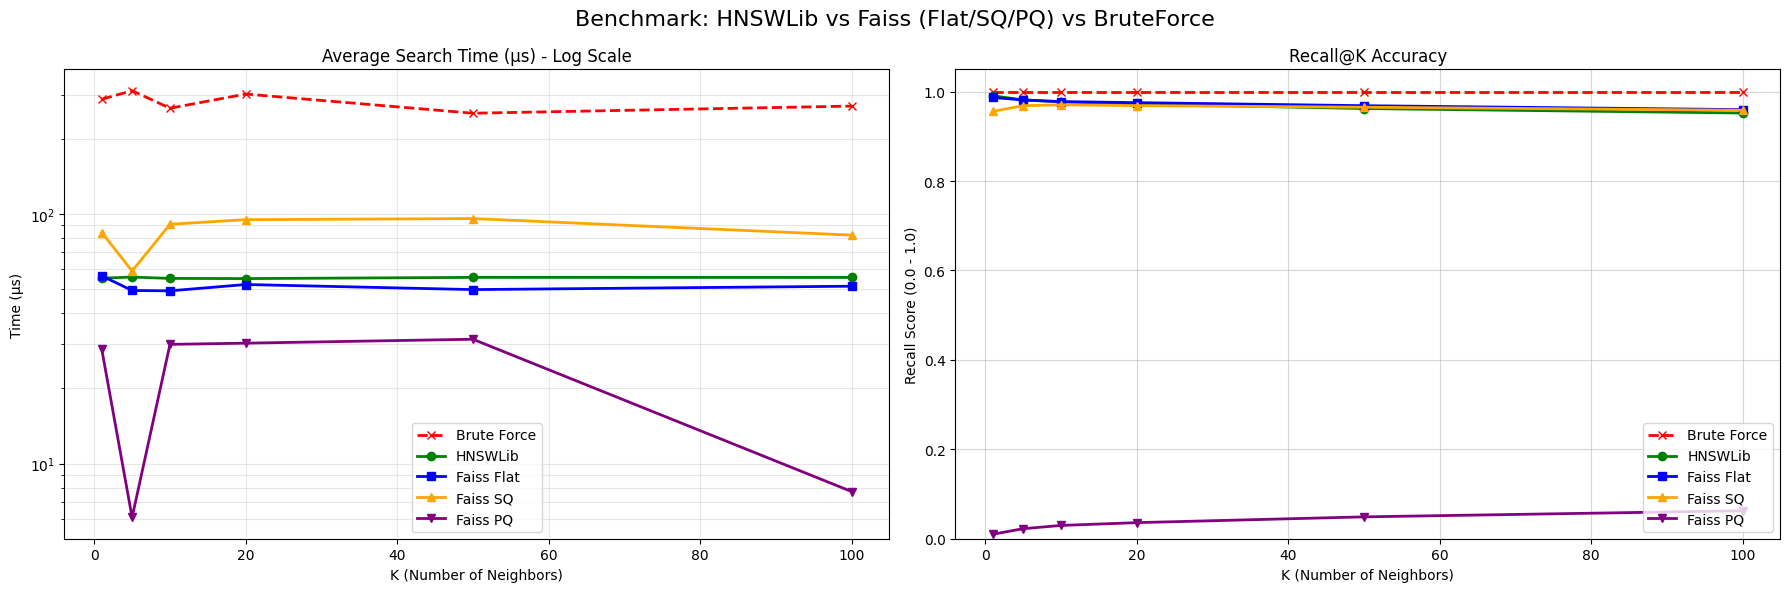

In [4]:
# --- PLOTTING: GENERAL BENCHMARK (ALL VARIANTS) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

k_vals = results_k['k']

# --- Định nghĩa style cho từng loại để đồng nhất màu sắc ---
styles = {
    'bf':   {'label': 'Brute Force', 'color': 'red',    'marker': 'x', 'linestyle': '--', 'linewidth': 2},
    'lib':  {'label': 'HNSWLib',     'color': 'green',  'marker': 'o', 'linestyle': '-',  'linewidth': 2},
    'flat': {'label': 'Faiss Flat',  'color': 'blue',   'marker': 's', 'linestyle': '-',  'linewidth': 2},
    'sq':   {'label': 'Faiss SQ',    'color': 'orange', 'marker': '^', 'linestyle': '-',  'linewidth': 2},
    'pq':   {'label': 'Faiss PQ',    'color': 'purple', 'marker': 'v', 'linestyle': '-',  'linewidth': 2},
}

# ==========================================
# PLOT 1: TIME COMPARISON (Log Scale)
# ==========================================

# 1. Brute Force
ax1.plot(k_vals, results_k['bf_time'], **styles['bf'])

# 2. HNSWLib
ax1.plot(k_vals, results_k['lib']['time'], **styles['lib'])

# 3. Faiss Variants
ax1.plot(k_vals, results_k['flat']['time'], **styles['flat'])
ax1.plot(k_vals, results_k['sq']['time'],   **styles['sq'])
ax1.plot(k_vals, results_k['pq']['time'],   **styles['pq'])

ax1.set_title('Average Search Time (µs) - Log Scale')
ax1.set_xlabel('K (Number of Neighbors)')
ax1.set_ylabel('Time (µs)')
ax1.set_yscale('log') # Quan trọng vì BF chậm hơn rất nhiều
ax1.grid(True, which="both", ls="-", alpha=0.3)
ax1.legend()


# ==========================================
# PLOT 2: RECALL ACCURACY
# ==========================================

# 1. Brute Force (Luôn là 1.0)
ax2.plot(k_vals, [1.0]*len(k_vals), **styles['bf'])

# 2. HNSWLib
ax2.plot(k_vals, results_k['lib']['recall'], **styles['lib'])

# 3. Faiss Variants
ax2.plot(k_vals, results_k['flat']['recall'], **styles['flat'])
ax2.plot(k_vals, results_k['sq']['recall'],   **styles['sq'])
ax2.plot(k_vals, results_k['pq']['recall'],   **styles['pq'])

ax2.set_title('Recall@K Accuracy')
ax2.set_xlabel('K (Number of Neighbors)')
ax2.set_ylabel('Recall Score (0.0 - 1.0)')
ax2.set_ylim(0, 1.05) # Giới hạn trục Y
ax2.grid(True, alpha=0.5)
ax2.legend(loc='lower right')

plt.suptitle("Benchmark: HNSWLib vs Faiss (Flat/SQ/PQ) vs BruteForce", fontsize=16)
plt.tight_layout()
plt.show()

# 5. Parameter Tuning Experiment (Deep Dive)

Runs a detailed experiment to see how the construction parameters (M, efConstruction) and search parameter (efSearch) affect performance at K=1. Brute Force timing is included in the innermost loop.

In [5]:
# --- 1. CONFIGURATION ---
M_values = [4, 8, 16, 32, 64]
efConst_values = [16, 64, 200]
efSearch_values = [10, 20, 40, 80, 120, 160, 200, 300]

# Danh sách thuật toán cần test
ALGO_LIST = ['HNSWLib', 'FaissFlat', 'FaissSQ', 'FaissPQ']

# Init results dictionary
experiment_results = {name: {} for name in ALGO_LIST}

print("\n🚀 STARTING UNIFIED EXPERIMENT (4 ALGORITHMS)...")
total_scenarios = len(ALGO_LIST) * len(efConst_values) * len(M_values)
step_count = 0

for algo_name in ALGO_LIST:
    print(f"\n{'='*40}")
    print(f"👉 RUNNING ALGORITHM: {algo_name}")
    print(f"{'='*40}")
    
    for efConst in efConst_values:
        experiment_results[algo_name][efConst] = {}
        
        for M in M_values:
            step_count += 1
            print(f"  [{step_count}/{total_scenarios}] {algo_name} | efConst={efConst} | M={M}...", end=" ")
            
            try:
                # --- A. BUILD INDEX ---
                index = None
                p_hnswlib = None # Placeholder cho HNSWLib
                
                if algo_name == 'HNSWLib':
                    p_hnswlib = hnswlib.Index(space='cosine', dim=DIM)
                    p_hnswlib.init_index(max_elements=NUM_ELEMENTS, ef_construction=efConst, M=M)
                    p_hnswlib.add_items(data)
                    
                elif algo_name == 'FaissFlat':
                    index = faiss.IndexHNSWFlat(DIM, M, faiss.METRIC_INNER_PRODUCT)
                    index.hnsw.efConstruction = efConst
                    index.add(data)
                    
                elif algo_name == 'FaissPQ':
                    m_pq = 16 
                    index = faiss.IndexHNSWPQ(DIM, m_pq, M)
                    index.metric_type = faiss.METRIC_INNER_PRODUCT
                    index.hnsw.efConstruction = efConst
                    index.train(data)
                    index.add(data)
                    
                elif algo_name == 'FaissSQ':
                    index = faiss.IndexHNSWSQ(DIM, faiss.ScalarQuantizer.QT_8bit, M, faiss.METRIC_INNER_PRODUCT)
                    index.hnsw.efConstruction = efConst
                    index.train(data)
                    index.add(data)

                # --- B. SEARCH LOOP ---
                recalls = []
                algo_times = []
                bf_times = []
                
                for ef in efSearch_values:
                    # 1. Set Parameters
                    if algo_name == 'HNSWLib':
                        p_hnswlib.set_ef(ef)
                    else:
                        index.hnsw.efSearch = ef
                        
                    # 2. Measure Algorithm Time
                    t0 = time.perf_counter()
                    if algo_name == 'HNSWLib':
                        labels, _ = p_hnswlib.knn_query(queries, k=1)
                    else:
                        _, labels = index.search(queries, k=1)
                    t1 = time.perf_counter()
                    algo_times.append(((t1 - t0) / NUM_QUERIES) * 1_000_000)
                    
                    # 3. Measure Brute-Force Realtime (như yêu cầu)
                    t0 = time.perf_counter()
                    _, _ = run_brute_force_cosine(data, queries, k=1)
                    t1 = time.perf_counter()
                    bf_times.append(((t1 - t0) / NUM_QUERIES) * 1_000_000)
                    
                    # 4. Recall
                    recalls.append(calculate_recall(gt_indices_k1, labels))
                    
                # Save Results
                experiment_results[algo_name][efConst][M] = {
                    'recall': recalls,
                    'time': algo_times,
                    'bf_time': bf_times
                }
                print(f"Done. Max Recall: {max(recalls):.4f}")
                
            except Exception as e:
                print(f"Error: {e}")

print("\n✅ All Experiments Completed!")


🚀 STARTING UNIFIED EXPERIMENT (4 ALGORITHMS)...

👉 RUNNING ALGORITHM: HNSWLib
  [1/60] HNSWLib | efConst=16 | M=4... Done. Max Recall: 0.5560
  [2/60] HNSWLib | efConst=16 | M=8... Done. Max Recall: 0.7570
  [3/60] HNSWLib | efConst=16 | M=16... Done. Max Recall: 0.8560
  [4/60] HNSWLib | efConst=16 | M=32... Done. Max Recall: 0.9670
  [5/60] HNSWLib | efConst=16 | M=64... Done. Max Recall: 0.9920
  [6/60] HNSWLib | efConst=64 | M=4... Done. Max Recall: 0.5930
  [7/60] HNSWLib | efConst=64 | M=8... Done. Max Recall: 0.8050
  [8/60] HNSWLib | efConst=64 | M=16... Done. Max Recall: 0.9290
  [9/60] HNSWLib | efConst=64 | M=32... Done. Max Recall: 0.9820
  [10/60] HNSWLib | efConst=64 | M=64... Done. Max Recall: 0.9940
  [11/60] HNSWLib | efConst=200 | M=4... Done. Max Recall: 0.6580
  [12/60] HNSWLib | efConst=200 | M=8... Done. Max Recall: 0.8200
  [13/60] HNSWLib | efConst=200 | M=16... Done. Max Recall: 0.9420
  [14/60] HNSWLib | efConst=200 | M=32... Done. Max Recall: 0.9920
  [15/60

# 6. Deep Dive Visualization (Recall & Speed)

Plots the Deep Dive results, comparing the performance of HNSW against the flat Brute Force line for different efSearch values.

In [6]:
# --- FUNCTION: PLOT REUSABLE ---
def plot_algorithm_performance(target_algo_name):
    # 1. Get Data
    if target_algo_name not in experiment_results:
        print(f"⚠️ No data found for {target_algo_name}")
        return
    
    current_data = experiment_results[target_algo_name]
    
    # 2. Setup Colors & Params
    M_values = [4, 8, 16, 32, 64]
    efConst_values = [16, 64, 200]
    colors = ['purple', 'cyan', 'green', 'orange', 'blue', 'red']
    color_map = dict(zip(M_values, colors))
    
    # ==========================
    # PLOT 1: RECALL vs efSEARCH
    # ==========================
    fig_recall, axes_recall = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    
    for i, efConst in enumerate(efConst_values):
        ax = axes_recall[i]
        
        if efConst in current_data:
            for M in M_values:
                if M in current_data[efConst]:
                    y_values = current_data[efConst][M]['recall']
                    x_vals = efSearch_values[:len(y_values)]
                    
                    ax.plot(x_vals, y_values, marker='.', linewidth=2,
                            color=color_map.get(M, 'gray'), label=f'M={M}')

        ax.set_title(f'efConstruction = {efConst}', fontsize=12, fontweight='bold', color='#333')
        ax.set_xlabel('efSearch (Query Effort)')
        if i == 0: ax.set_ylabel('Recall@1 Score')
        ax.set_ylim(0, 1.05)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if i == 2: ax.legend(title='M (Links)', loc='lower right')

    plt.suptitle(f"Accuracy (Recall@1) - {target_algo_name}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    # ==========================
    # PLOT 2: TIME vs efSEARCH
    # ==========================
    fig_time, axes_time = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Calculate Y-axis scaling specific to this algorithm
    all_times = []
    bf_time_to_plot = []

    for ef in current_data:
        for M in current_data[ef]:
            all_times.extend(current_data[ef][M]['time'])
            if not bf_time_to_plot:
                bf_time_to_plot = current_data[ef][M]['bf_time']

    y_min = min(all_times) * 0.8 if all_times else 10
    max_bf = max(bf_time_to_plot) if bf_time_to_plot else 0
    y_max = max(max(all_times) if all_times else 0, max_bf) * 1.5 

    for i, efConst in enumerate(efConst_values):
        ax = axes_time[i]

        # 1. Plot HNSW curves
        if efConst in current_data:
            for M in M_values:
                if M in current_data[efConst]:
                    y_values = current_data[efConst][M]['time']
                    x_vals = efSearch_values[:len(y_values)]
                    
                    ax.plot(x_vals, y_values, marker='.', linewidth=2,
                            color=color_map.get(M, 'gray'), label=f'M={M}')

        # 2. Plot Brute Force Baseline
        if bf_time_to_plot:
            bf_vals = bf_time_to_plot[:len(efSearch_values)]
            ax.plot(efSearch_values[:len(bf_vals)], bf_vals, color='red', linestyle='-', linewidth=3, label='Brute Force (Baseline)')

        # Styling
        ax.set_title(f'efConstruction = {efConst}', fontsize=12, fontweight='bold', color='#333')
        ax.set_xlabel('efSearch')
        ax.set_yscale('log')
        ax.set_ylim(y_min, y_max)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if i == 0: ax.set_ylabel('Search Time (µs) - Log Scale')
        if i == 2: 
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = []
            unique_handles = []
            for h, l in zip(handles, labels):
                if l not in unique_labels:
                    unique_labels.append(l)
                    unique_handles.append(h)
            ax.legend(unique_handles, unique_labels, title='Parameters', loc='center right', bbox_to_anchor=(1.4, 0.5))

    plt.suptitle(f"Search Speed - {target_algo_name}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

📊 Generating plots for HNSWLib...


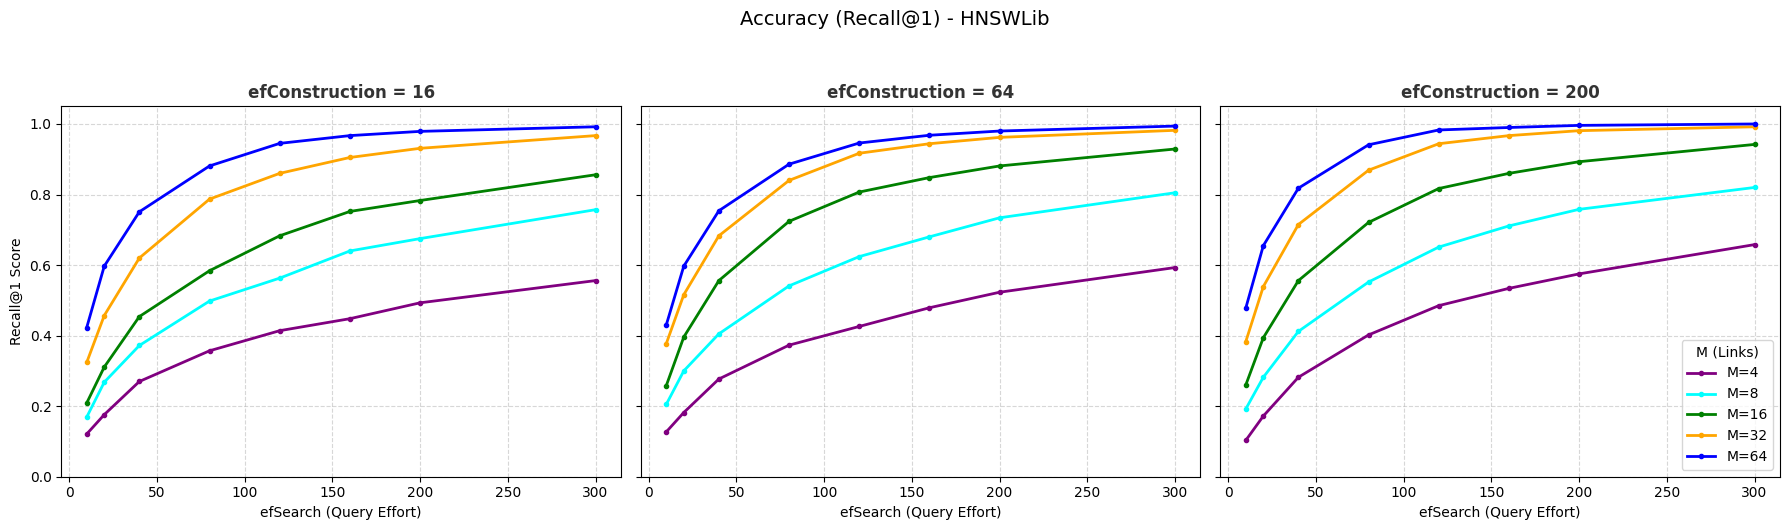

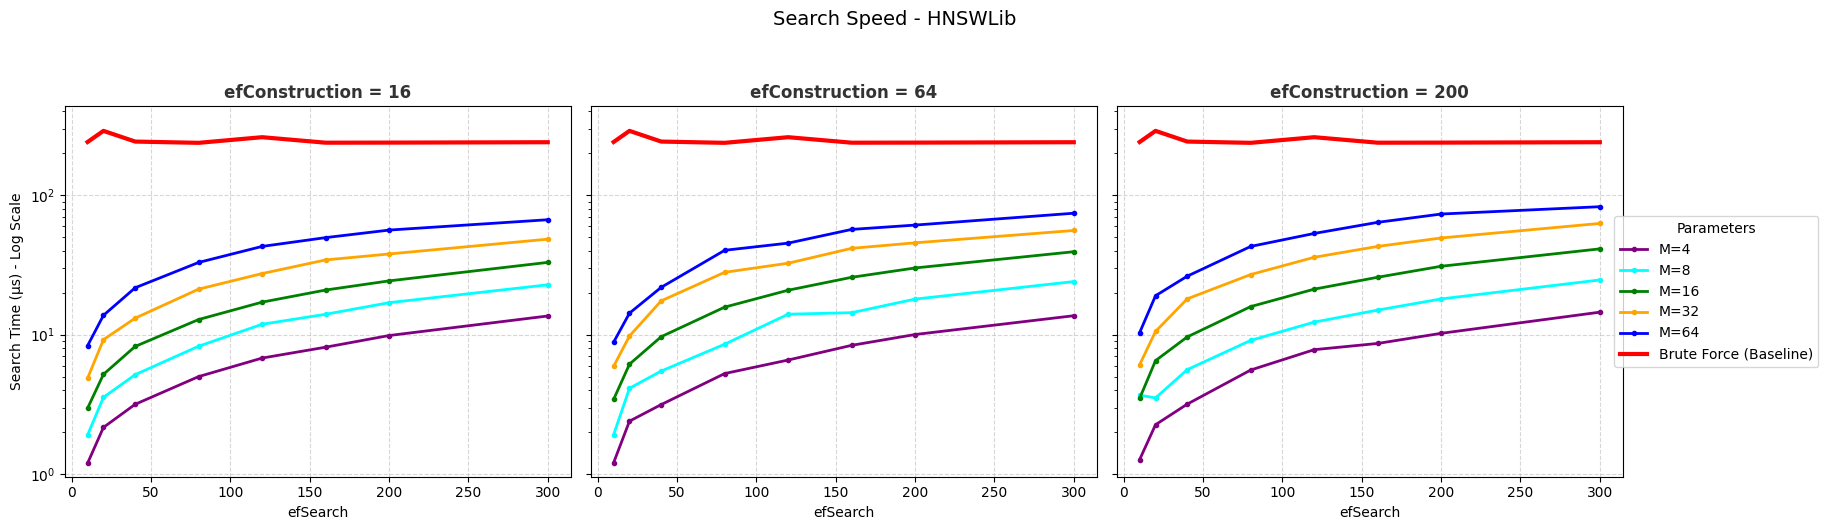

In [7]:
print("📊 Generating plots for HNSWLib...")
plot_algorithm_performance('HNSWLib')


📊 Generating plots for Faiss Flat...


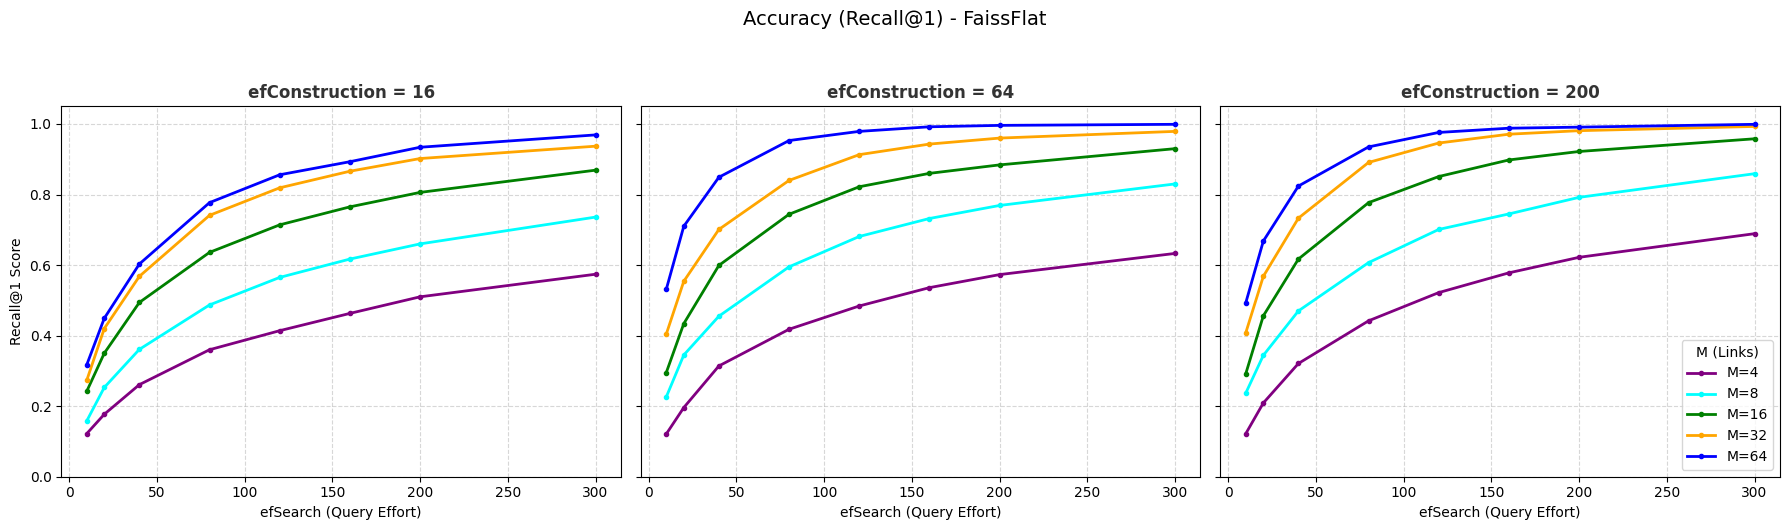

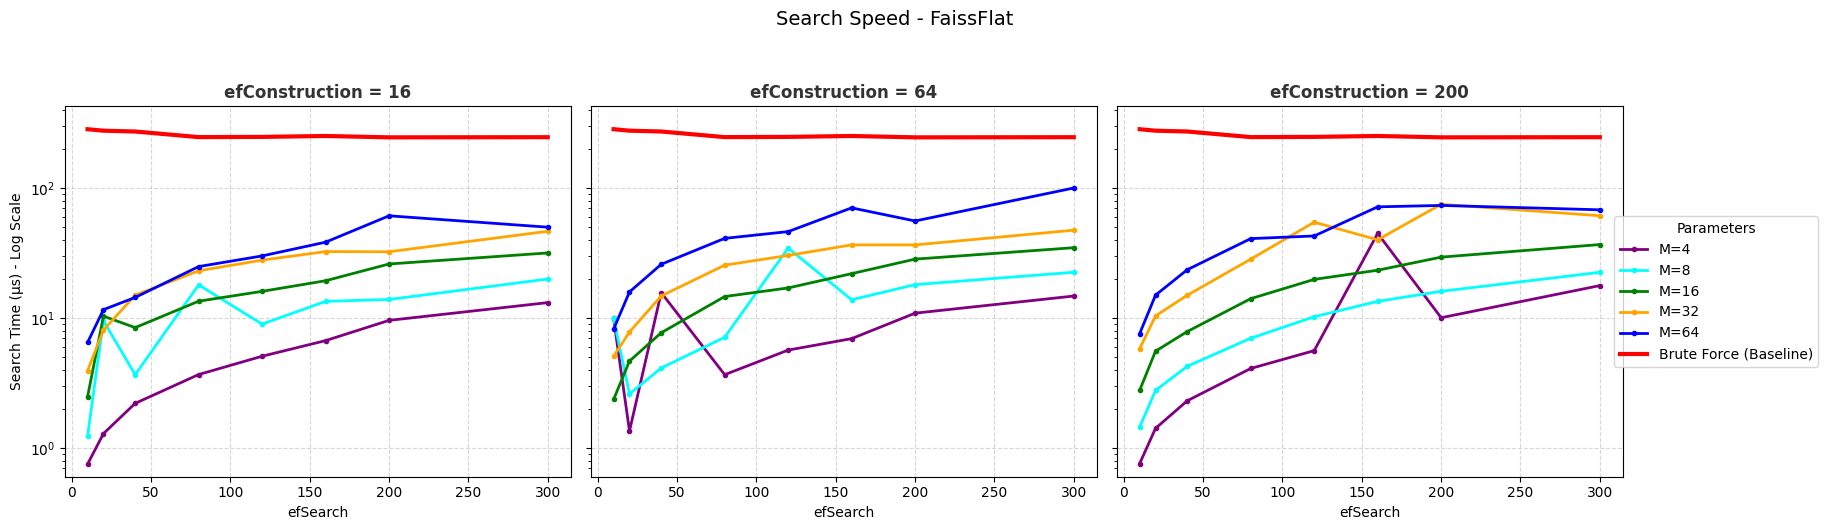

In [8]:
print("\n📊 Generating plots for Faiss Flat...")
plot_algorithm_performance('FaissFlat')


📊 Generating plots for Faiss SQ...


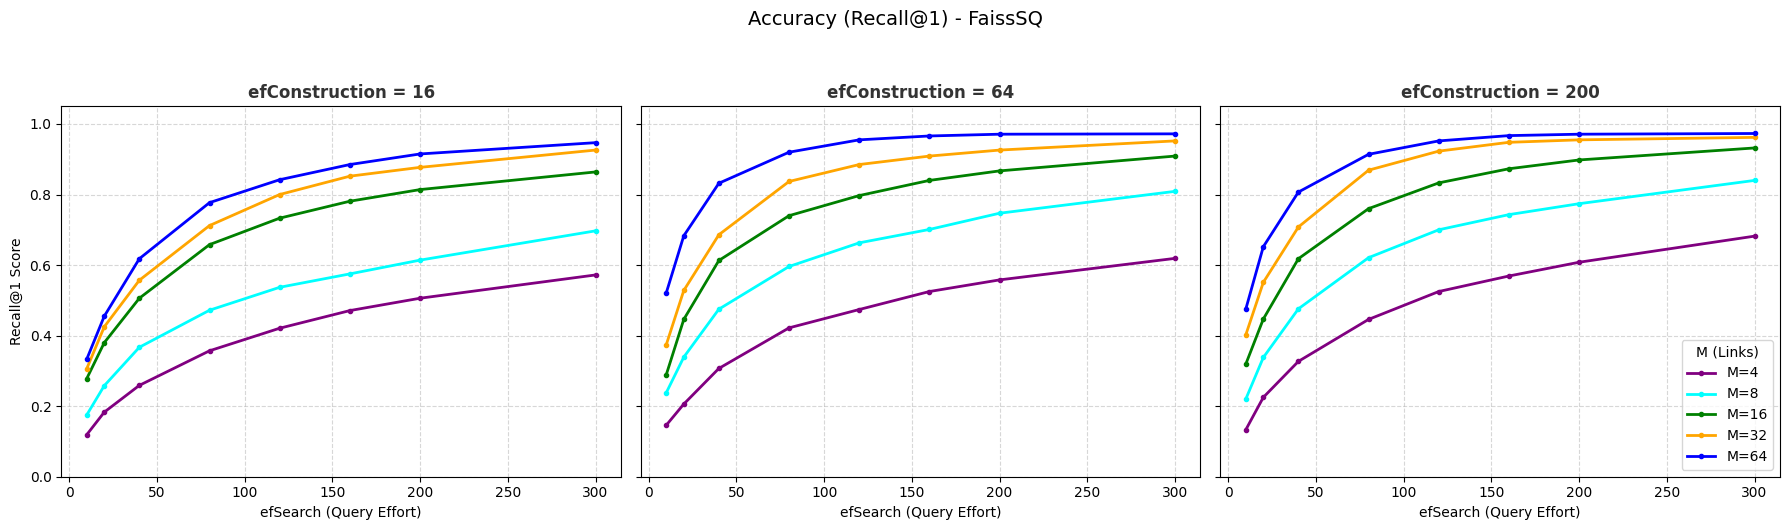

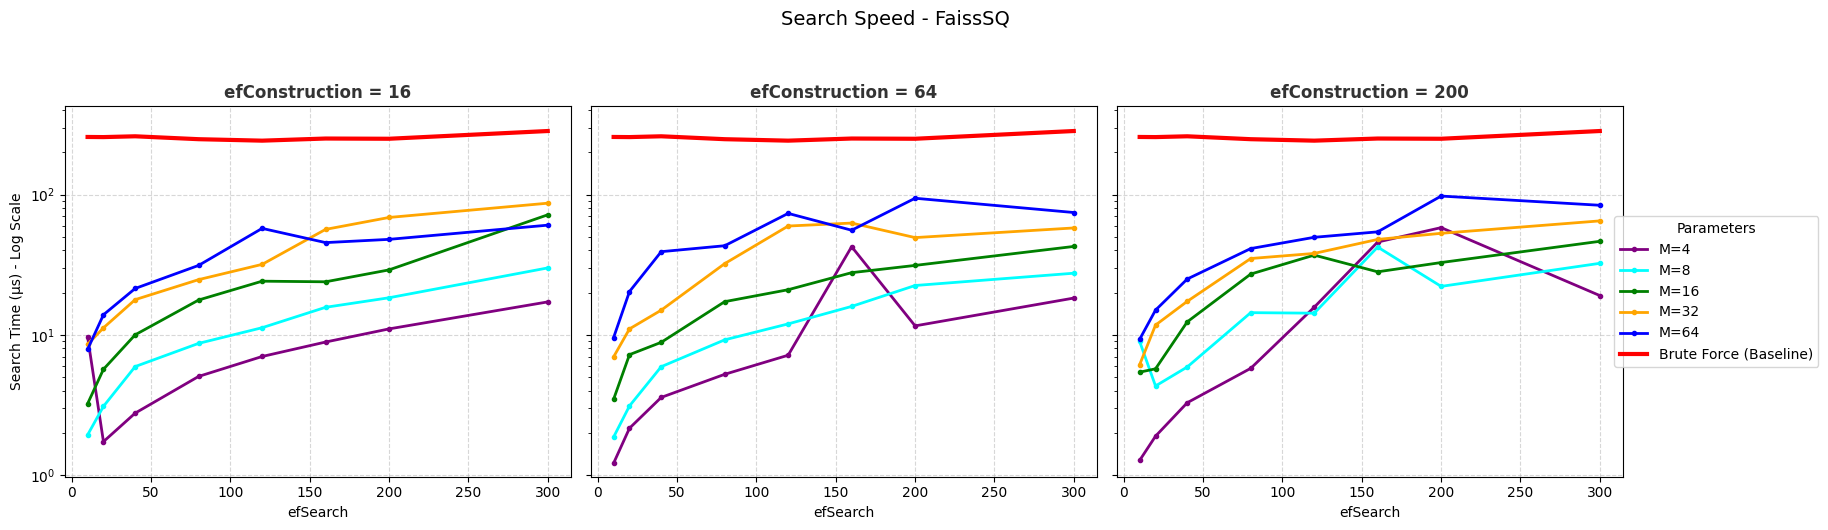

In [9]:
print("\n📊 Generating plots for Faiss SQ...")
plot_algorithm_performance('FaissSQ')


📊 Generating plots for Faiss PQ...


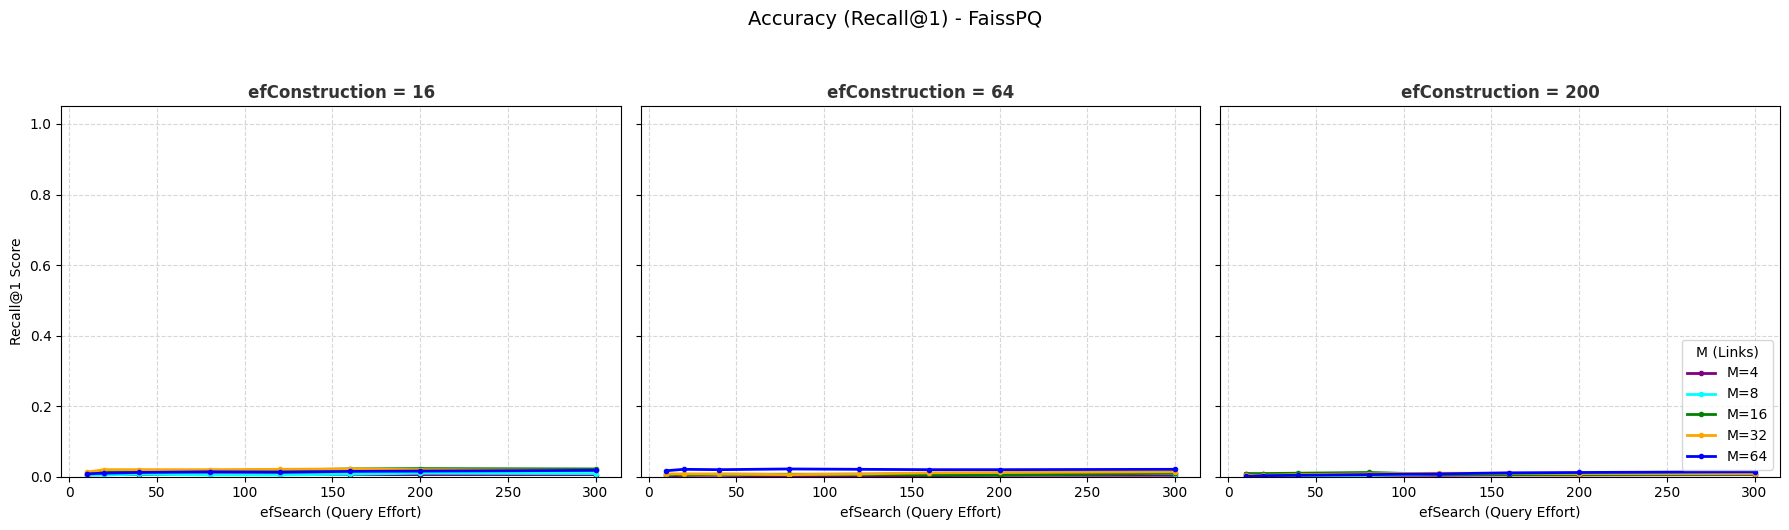

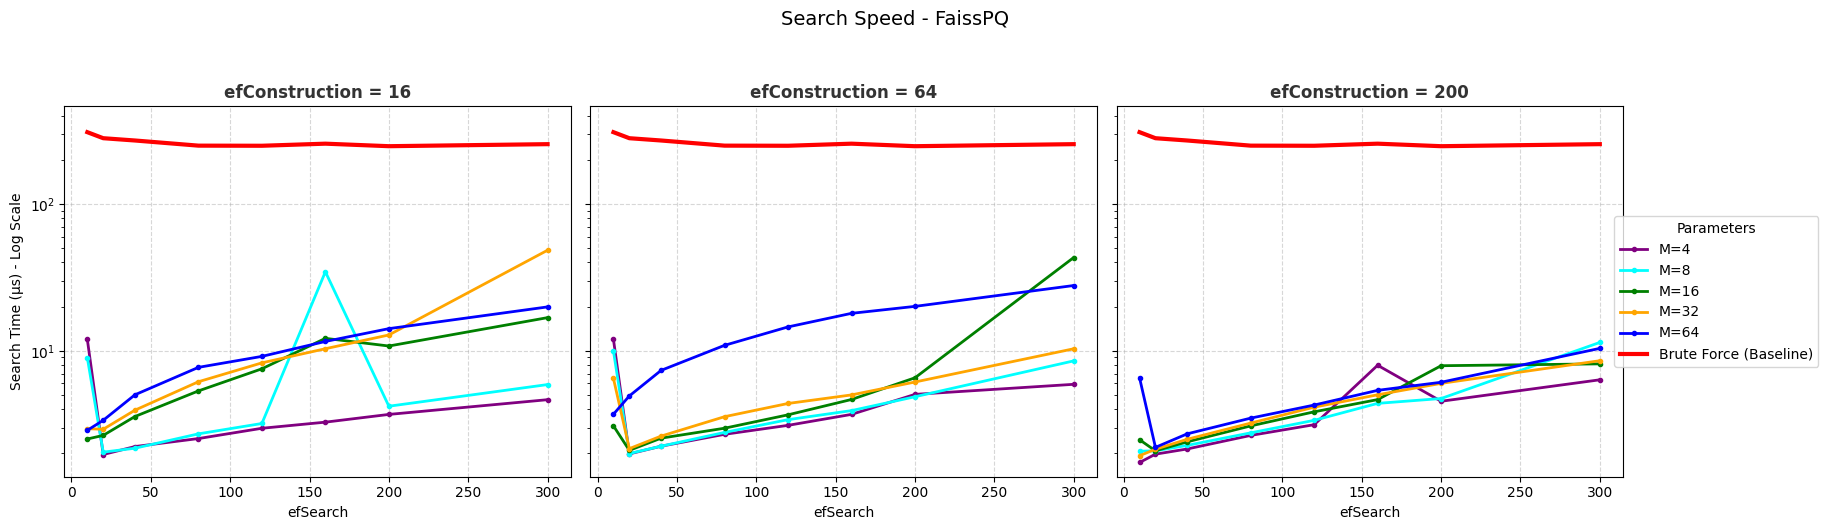

In [10]:
print("\n📊 Generating plots for Faiss PQ...")
plot_algorithm_performance('FaissPQ')

# 7. Simulated Graph Structure Analysis

Simulates and visualizes the hierarchical and connectivity structure of the HNSW graph.

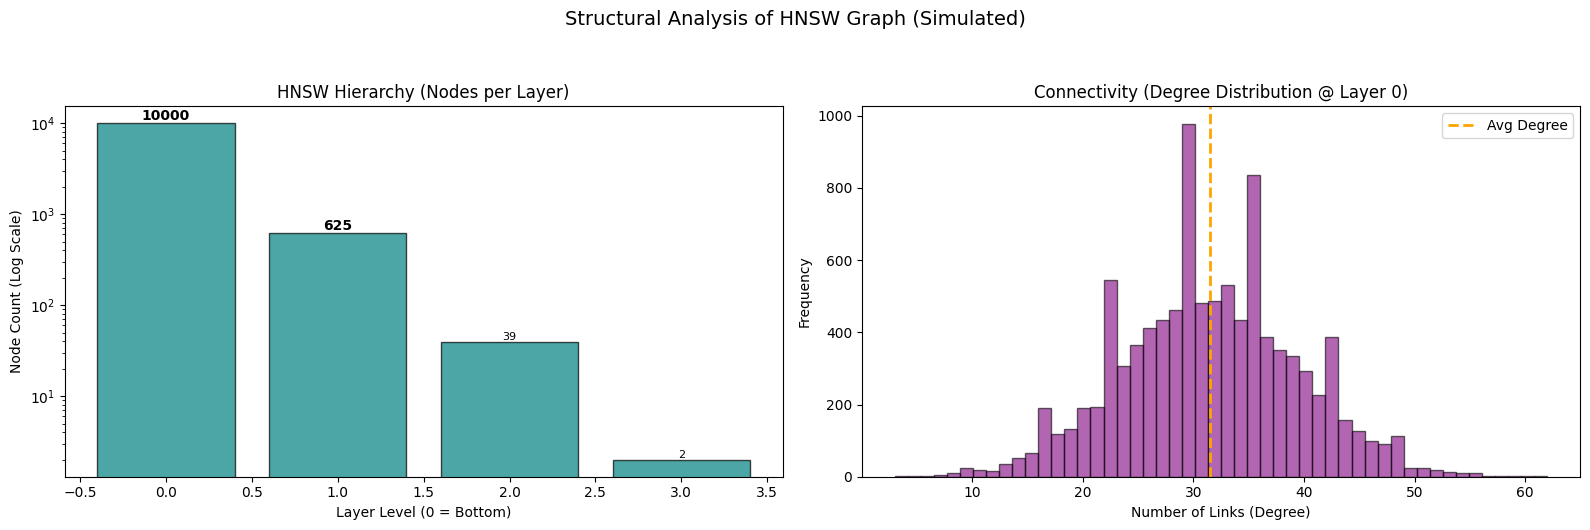

In [11]:
# --- GRAPH STRUCTURE ANALYSIS (Simulation) ---

def simulate_hnsw_structure(num_elements, M):
    """Simulates the layer and degree structure of the HNSW graph."""
    layers = []
    # Layer 0 (Bottom Layer): Contains all nodes
    deg_L0 = np.random.normal(loc=M*2, scale=M/2, size=num_elements).astype(int)
    deg_L0 = np.clip(deg_L0, 1, None) 
    layers.append(deg_L0)
    
    # Upper Layers: Node count decays exponentially (1/M)
    count = num_elements
    while count > M:
        count = int(count / M)
        if count == 0: break
        deg = np.random.normal(loc=M, scale=M/4, size=count).astype(int)
        layers.append(deg)
    return layers

# Generate mock data for M=16
mock_layers = simulate_hnsw_structure(NUM_ELEMENTS, 16)
node_counts = [len(l) for l in mock_layers]

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Hierarchy (Nodes per Layer)
ax1.bar(range(len(node_counts)), node_counts, color='teal', alpha=0.7, edgecolor='black')
ax1.set_yscale('log')
ax1.set_title('HNSW Hierarchy (Nodes per Layer)')
ax1.set_xlabel('Layer Level (0 = Bottom)')
ax1.set_ylabel('Node Count (Log Scale)')
for i, v in enumerate(node_counts):
    if v > 100:
        ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    else:
         ax1.text(i, v, str(v), ha='center', va='bottom', fontsize=8)


# Plot 2: Connectivity (Degree Distribution @ Layer 0)
ax2.hist(mock_layers[0], bins=50, color='purple', alpha=0.6, edgecolor='black')
ax2.axvline(np.mean(mock_layers[0]), color='orange', linestyle='--', linewidth=2, label='Avg Degree')
ax2.set_title('Connectivity (Degree Distribution @ Layer 0)')
ax2.set_xlabel('Number of Links (Degree)')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.suptitle("Structural Analysis of HNSW Graph (Simulated)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()


🧪 Testing Scenario: DIM=128, N=50000...

🧪 Testing Scenario: DIM=128, N=100000...

🧪 Testing Scenario: DIM=128, N=200000...

🧪 Testing Scenario: DIM=512, N=50000...

🧪 Testing Scenario: DIM=512, N=100000...

🧪 Testing Scenario: DIM=512, N=200000...

📊 Plotting Multi-Scenario Results...


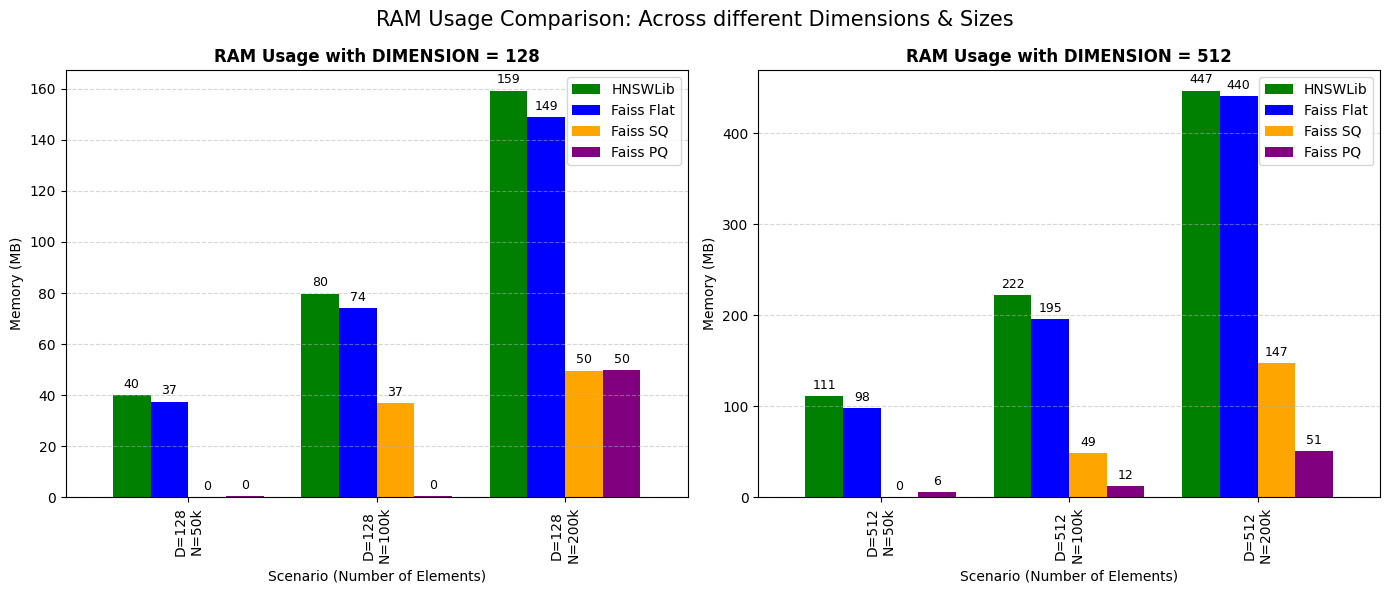


📋 Summary Table (MB):
                  HNSWLib  Faiss Flat    Faiss SQ   Faiss PQ
D=128\nN=50k    39.980469   37.453125    0.000000   0.296875
D=128\nN=100k   79.753906   74.246094   36.898438   0.296875
D=128\nN=200k  159.269531  148.785156   49.621094  49.917969
D=512\nN=50k   110.910156   97.660156    0.000000   6.015625
D=512\nN=100k  221.726562  195.316406   48.832031  11.894531
D=512\nN=200k  446.593750  440.250000  147.281250  50.511719


In [12]:
DIMS_TO_TEST = [128, 512]            # Vector ngắn vs Vector dài (như CLIP/BERT)
NUMS_TO_TEST = [50000, 100000, 200000]       # Database nhỏ vs Database vừa
M_PARAM = 32
EF_CONST = 200

# Hàm đo RAM
def get_current_ram_mb():
    pid = os.getpid()
    return psutil.Process(pid).memory_info().rss / 1024 / 1024

def measure_scenario(dim, num_elements):
    print(f"\n🧪 Testing Scenario: DIM={dim}, N={num_elements}...")
    
    # Generate Data
    data = np.random.random((num_elements, dim)).astype(np.float32)
    faiss.normalize_L2(data)
    
    results = {}
    
    # --- Helper để đo và dọn dẹp ---
    def run_build(name, build_fn):
        gc.collect()
        start = get_current_ram_mb()
        idx = build_fn()
        end = get_current_ram_mb()
        usage = max(0, end - start)
        results[name] = usage
        del idx
        gc.collect()

    # 1. HNSWLib
    def build_lib():
        p = hnswlib.Index(space='cosine', dim=dim)
        p.init_index(max_elements=num_elements, ef_construction=EF_CONST, M=M_PARAM)
        p.add_items(data)
        return p
    run_build('HNSWLib', build_lib)
    
    # 2. Faiss Flat
    def build_flat():
        idx = faiss.IndexHNSWFlat(dim, M_PARAM, faiss.METRIC_INNER_PRODUCT)
        idx.hnsw.efConstruction = EF_CONST
        idx.add(data)
        return idx
    run_build('Faiss Flat', build_flat)
    
    # 3. Faiss SQ (8-bit)
    def build_sq():
        idx = faiss.IndexHNSWSQ(dim, faiss.ScalarQuantizer.QT_8bit, M_PARAM, faiss.METRIC_INNER_PRODUCT)
        idx.hnsw.efConstruction = EF_CONST
        idx.train(data)
        idx.add(data)
        return idx
    run_build('Faiss SQ', build_sq)
    
    # 4. Faiss PQ (Adaptive m)
    # PQ yêu cầu dim phải chia hết cho m. Ta chọn m sao cho mỗi sub-vector khoảng 8 chiều.
    # Ví dụ: Dim 128 -> m=16. Dim 512 -> m=64.
    m_pq = int(dim / 8) 
    def build_pq():
        idx = faiss.IndexHNSWPQ(dim, m_pq, M_PARAM)
        idx.metric_type = faiss.METRIC_INNER_PRODUCT
        idx.hnsw.efConstruction = EF_CONST
        idx.train(data)
        idx.add(data)
        return idx
    run_build('Faiss PQ', build_pq)
    
    # Xóa data to để giải phóng RAM cho vòng lặp sau
    del data
    gc.collect()
    
    return results

# --- 2. RUN LOOP ---
benchmark_data = {}

for dim in DIMS_TO_TEST:
    for num in NUMS_TO_TEST:
        key = f"D={dim}\nN={num//1000}k"
        benchmark_data[key] = measure_scenario(dim, num)

# --- 3. VISUALIZATION ---
print("\n📊 Plotting Multi-Scenario Results...")

df = pd.DataFrame(benchmark_data).T
# df có dạng: Index=(Scenario), Columns=(Algos), Values=(MB Usage)

fig, axes = plt.subplots(1, len(DIMS_TO_TEST), figsize=(14, 6))
if len(DIMS_TO_TEST) == 1: axes = [axes]

colors = ['green', 'blue', 'orange', 'purple']

for i, dim in enumerate(DIMS_TO_TEST):
    ax = axes[i]
    # Lọc các row có DIM tương ứng
    subset = df[df.index.str.contains(f"D={dim}")]
    
    # Vẽ Grouped Bar Chart
    subset.plot(kind='bar', ax=ax, color=colors, width=0.8)
    
    ax.set_title(f'RAM Usage with DIMENSION = {dim}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory (MB)')
    ax.set_xlabel('Scenario (Number of Elements)')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Thêm text giá trị lên cột
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.suptitle("RAM Usage Comparison: Across different Dimensions & Sizes", fontsize=15)
plt.tight_layout()
plt.show()

# --- 4. SUMMARY TABLE ---
print("\n📋 Summary Table (MB):")
print(df)